<a href="https://colab.research.google.com/github/songchanho97/metastaic_cancer_prediction/blob/main/Final_804_%ED%98%BC%EB%8F%99%ED%96%89%EB%A0%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

In [3]:
# Import Libraries

import numpy as np # linear algebra
import pandas as pd # for data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visulaization
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost
import xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load datasets

In [5]:
ls

drive/  sample_data/


In [6]:
# Load Competiton Datasets and drop breast_cancer_diagnosis_code
df = pd.read_csv("/content/drive/MyDrive/2025_DataMining/WiDS/training.csv")
tdf = pd.read_csv("/content/drive/MyDrive/2025_DataMining/WiDS/test.csv")
ss = pd.read_csv("/content/drive/MyDrive/2025_DataMining/WiDS/sample_submission.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

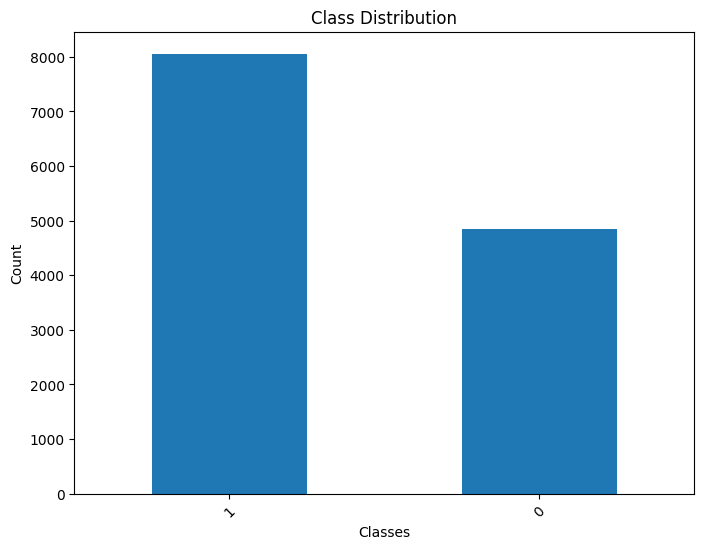

In [ ]:
target = "DiagPeriodL90D"

# Count the occurrences of each class
class_counts = df[target].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

### NO2, PM25, commute_time - Missing Value

- patient_zip2 기반의 평균값으로 대체

In [ ]:
# patient_zip2 파생 변수 생성
df['patient_zip2'] = df['patient_zip3'].astype(str).str[:2]
tdf['patient_zip2'] = tdf['patient_zip3'].astype(str).str[:2]


# 전처리할 컬럼 리스트
target_cols = ['N02', 'PM25', 'commute_time']

# df, tdf 각각에 대해 그룹별 평균으로 결측치 채우기
for dataset in [df, tdf]:
    for col in target_cols:
        dataset[col] = dataset.groupby('patient_zip2')[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# 각 컬럼의 결측치 개수 출력
for col in ['N02', 'PM25', 'commute_time']:
    missing_count = df[col].isnull().sum()
    print(f"{col} 결측치 개수: {missing_count}")

N02 결측치 개수: 0
PM25 결측치 개수: 0
commute_time 결측치 개수: 0


### NO2 x PM25 x commute_time + MinMax Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 스케일링 대상 컬럼
cols = ['N02', 'PM25', 'commute_time']

# MinMax 스케일러 정의
scaler = MinMaxScaler()

# df 정규화
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols, index=df.index)
df['N02xPM25xcommute_time'] = df_scaled['N02'] * df_scaled['PM25'] * df_scaled['commute_time']

# tdf 정규화 (df 기준으로 transform)
tdf_scaled = pd.DataFrame(scaler.transform(tdf[cols]), columns=cols, index=tdf.index)
tdf['N02xPM25xcommute_time'] = tdf_scaled['N02'] * tdf_scaled['PM25'] * tdf_scaled['commute_time']

### train + test

In [ ]:
# define target variable and categorical features
cat_cols = list(tdf.columns[tdf.dtypes=="object"])
cols = [col for col in tdf.columns if col not in ["patient_id"]]
tdf[target] = np.nan

# concatenate train and test set
df = pd.concat([df,tdf[df.columns]],axis=0)

### clust + is_female

In [ ]:
df["clust"]=(df.metastatic_cancer_diagnosis_code.str.len()==4).astype("int")
df["is_female"] = df.breast_cancer_diagnosis_desc.str.contains("female").astype("int")
df["is_female"].value_counts()

,count
is_female,
1,18665
0,33


### meta_code4

In [ ]:
# meta 칼럼에서 5자리 값을 4자리로 변환
df['meta_code4'] = df['metastatic_cancer_diagnosis_code'].astype(str).apply(lambda x: x[:4] if len(x) >= 5 else x)

# 결과 확인
print(df['meta_code4'].nunique())
print(df['meta_code4'].value_counts())

#metastatic_cancer_diagnosis_code 드랍하기
df = df.drop(columns=['metastatic_cancer_diagnosis_code'])

27
meta_code4
C773    10223
C795     2760
C798     1196
C779     1095
C780      910
C787      533
C799      399
C793      389
C792      239
C771      226
C770      192
C782      117
C778      116
C786       57
C781       40
C772       39
C794       29
C796       27
C788       25
C785       25
C797       17
C775       14
C790        8
C791        7
C784        6
C783        5
C774        4
Name: count, dtype: int64


### ICD

In [ ]:
# ICD_version 파생변수 생성 (ICD-10이면 0, ICD-9이면 1)

df['ICD_version'] = np.where(df['breast_cancer_diagnosis_code'].astype(str).str.startswith('C'), 'ICD-10', 'ICD-9')
print(df['ICD_version'].value_counts())

ICD_version
ICD-10    14333
ICD-9      4365
Name: count, dtype: int64


### Breast Cancer - Code & Desc Mapping

In [ ]:
# ## ICD9 -> ICD10 매핑
# ## breast_cancer_diagnosis_desc
# ## breast_cancer_diagnosis_code

# # 1. ICD9 -> ICD10 코드(code) 매핑
# icd9_to_icd10 = {
#     '1749': 'C50919', '1744': 'C50419',
#     '1748': 'C50819', '1742': 'C50219',
#     '1741': 'C50119', '1745': 'C50519',
#     '1743': 'C50319', '1746': 'C50619',
#     '19881': 'C7981', '1759': 'C50929'
# }

# # 2. ICD-10 ➝ 진단명(desc) 매핑
# icd10_to_desc = {
#     "C50919": "Malignant neoplasm of unsp site of unspecified female breast",
#     "C50419": "Malig neoplasm of upper-outer quadrant of unsp female breast",
#     "C50819": "Malignant neoplasm of ovrlp sites of unsp female breast",
#     "C50219": "Malig neoplasm of upper-inner quadrant of unsp female breast",
#     "C50119": "Malignant neoplasm of central portion of unsp female breast",
#     "C50519": "Malig neoplasm of lower-outer quadrant of unsp female breast",
#     "C50319": "Malig neoplasm of lower-inner quadrant of unsp female breast",
#     "C50619": "Malignant neoplasm of axillary tail of unsp female breast",
#     "C50929": "Malignant neoplasm of unsp site of unspecified male breast",
#     "C7981": "Secondary malignant neoplasm of breast"
# }


# # 1-(1). ICD9 -> ICD10 코드(code) 매핑 적용
# df['breast_cancer_diagnosis_code_mapped'] = df['breast_cancer_diagnosis_code'].astype(str).replace(icd9_to_icd10)

# # 2-(2). ICD-10 ➝ 진단명(desc) 매핑 적용
# df['breast_cancer_diagnosis_desc_mapped'] = df['breast_cancer_diagnosis_code_mapped'].map(icd10_to_desc).fillna(df['breast_cancer_diagnosis_desc'])

## tumor_site

In [ ]:
# # desc를 소문자로 변환하여 새로운 컬럼 생성
# df['desc_lower'] = df['breast_cancer_diagnosis_desc_mapped'].str.lower()

# # 위치 기반 파생 변수 생성
# df['tumor_site'] = np.select(
#     [
#         df['desc_lower'].str.contains('inner'),
#         df['desc_lower'].str.contains('outer') | df['desc_lower'].str.contains('axillary tail'),
#         df['desc_lower'].str.contains('central portion') | df['desc_lower'].str.contains('nipple') | df['desc_lower'].str.contains('areola'),
#         df['desc_lower'].str.contains('overlapping') | df['desc_lower'].str.contains('ovrlp'),
#         df['desc_lower'].str.contains('unspecified') | df['desc_lower'].str.contains('unsp')
#     ],
#     [
#         'Inner',
#         'Outer',
#         'Central',
#         'Overlapping',
#         'Unspecified'
#     ],
#     default='Unspecified'
# )
# df['tumor_site'].value_counts()

## patient_race - Missing Value

In [ ]:
## 해야해

## Columns Drop (zip3 Groupby & others

In [ ]:
len(df.columns)

88

In [ ]:
# Drop some features

# List of columns to iterate over
columns_to_iterate = [col for col in df.columns if col not in ["patient_zip3", "N02xPM25xcommute_time"]]

# Iterate over each column
for col in columns_to_iterate:
    # Your code to operate on each column goes here
    df["check"]=df.groupby(["patient_zip3","N02xPM25xcommute_time"])[col].transform("nunique")
    if df["check"].max()==1:
        print("dropped ",col)
        df=df.drop(col,axis=1)
        # tdf=tdf.drop(col,axis=1)
df=df.drop("check",axis=1)

dropped  patient_gender
dropped  metastatic_first_novel_treatment
dropped  metastatic_first_novel_treatment_type
dropped  population
dropped  density
dropped  age_median
dropped  age_under_10
dropped  age_10_to_19
dropped  age_20s
dropped  age_30s
dropped  age_40s
dropped  age_50s
dropped  age_60s
dropped  age_70s
dropped  age_over_80
dropped  male
dropped  female
dropped  married
dropped  divorced
dropped  never_married
dropped  widowed
dropped  family_size
dropped  family_dual_income
dropped  income_household_median
dropped  income_household_under_5
dropped  income_household_5_to_10
dropped  income_household_10_to_15
dropped  income_household_15_to_20
dropped  income_household_20_to_25
dropped  income_household_25_to_35
dropped  income_household_35_to_50
dropped  income_household_50_to_75
dropped  income_household_75_to_100
dropped  income_household_100_to_150
dropped  income_household_150_over
dropped  income_household_six_figure
dropped  income_individual_median
dropped  home_owner

In [ ]:
# - Region
# - patient_zip3
# - desc_lower
# - breast_cancer_diagnosis_code
# - breast_cancer_diagnosis_desc
# - breast_cancer_diagnosis_code_mapped
# - breast_cancer_diagnosis_desc_mapped

df = df.drop(columns=[
    'Region', 'patient_zip3',
    # 'desc_lower',
    # 'breast_cancer_diagnosis_code_mapped',
    # 'breast_cancer_diagnosis_desc_mapped',
    # 'breast_cancer_diagnosis_desc',
    'breast_cancer_diagnosis_code',
])

In [ ]:
df.columns.to_list()

['patient_id',
 'patient_race',
 'payer_type',
 'patient_state',
 'patient_age',
 'bmi',
 'breast_cancer_diagnosis_desc',
 'Division',
 'DiagPeriodL90D',
 'N02xPM25xcommute_time',
 'clust',
 'is_female',
 'meta_code4',
 'ICD_version']

In [ ]:
len(df.columns)

14

## One-Hot Encoding

In [ ]:
# One-Hot Encoding
categorical_cols = [col for col in df.columns
                    if df[col].dtype == 'object']

In [ ]:
categorical_cols

['patient_race',
 'payer_type',
 'patient_state',
 'breast_cancer_diagnosis_desc',
 'Division',
 'meta_code4',
 'ICD_version']

In [ ]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype="int")

In [ ]:
# do label encoding for categorical columns
le = LabelEncoder()
for col in cat_cols:
    try:
        df[col]=le.fit_transform(df[col]).astype("int")
        print(col)
    except:
        continue

In [ ]:
tdf = df[df[target].isna()]
df = df[df[target].notna()]
len(df), len(tdf)
# 분리하는 코드

(12906, 5792)

# Data Cleaning

Zip code level metadata were dropped except product of N02,PM25 & Ozone

Data set contained missing values which we left unhandled


In [ ]:
len(df.columns)

148

In [ ]:
for col in df.columns:
    print(col)

patient_id
patient_age
bmi
DiagPeriodL90D
N02xPM25xcommute_time
clust
is_female
patient_race_Black
patient_race_Hispanic
patient_race_Other
patient_race_White
payer_type_MEDICAID
payer_type_MEDICARE ADVANTAGE
patient_state_AL
patient_state_AR
patient_state_AZ
patient_state_CA
patient_state_CO
patient_state_CT
patient_state_DC
patient_state_DE
patient_state_FL
patient_state_GA
patient_state_HI
patient_state_IA
patient_state_ID
patient_state_IL
patient_state_IN
patient_state_KS
patient_state_KY
patient_state_LA
patient_state_MA
patient_state_MD
patient_state_MI
patient_state_MN
patient_state_MO
patient_state_MS
patient_state_MT
patient_state_NC
patient_state_ND
patient_state_NE
patient_state_NH
patient_state_NJ
patient_state_NM
patient_state_NV
patient_state_NY
patient_state_OH
patient_state_OK
patient_state_OR
patient_state_PA
patient_state_PR
patient_state_RI
patient_state_SC
patient_state_SD
patient_state_TN
patient_state_TX
patient_state_UT
patient_state_VA
patient_state_WA
patient_s

# Modeling

In [ ]:
# ▶ CatBoost
modela = CatBoostClassifier(
    iterations = 500,
    silent = True,
    learning_rate = 0.05,
    depth = 10,
    eval_metric = 'AUC',
    random_seed = 42
)

# ▶ RandomForest
modelb = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    min_samples_split = 2,
    random_state = 42,
    n_jobs = -1
)

# ▶ XGBoost
modelc = XGBClassifier(
    learning_rate = 0.1,
    max_depth = 6,
    n_estimators = 100,
    subsample = 0.9
)

In [ ]:
# finalize features for training
drop_cols = ["patient_id", target, "patient_zip3", "patient_state"]
cols = list(set(df.columns) - set(drop_cols))

In [ ]:
print("모델 학습에 사용된 feature 개수:", len(cols))
print("사용된 feature 리스트:")
for col in cols:
    print(col)

모델 학습에 사용된 feature 개수: 146
사용된 feature 리스트:
patient_state_KY
breast_cancer_diagnosis_desc_Secondary malignant neoplasm of breast
meta_code4_C785
breast_cancer_diagnosis_desc_Malignant neoplasm of nipple and areola, female
patient_state_NE
N02xPM25xcommute_time
is_female
patient_state_CO
meta_code4_C771
patient_state_HI
patient_state_DC
clust
breast_cancer_diagnosis_desc_Malignant neoplasm of upper-inner quadrant of breast, female
breast_cancer_diagnosis_desc_Malignant neoplasm of unspecified site of left male breast
meta_code4_C788
patient_state_MS
patient_state_WY
Division_West South Central
patient_state_MI
breast_cancer_diagnosis_desc_Malig neoplasm of upper-inner quadrant of unsp female breast
payer_type_MEDICAID
patient_state_IA
patient_state_DE
patient_state_MD
patient_state_WA
Division_New England
patient_state_MO
breast_cancer_diagnosis_desc_Malignant neoplasm of unsp site of unspecified male breast
breast_cancer_diagnosis_desc_Malig neoplasm of upper-inner quadrant of left fem

In [ ]:
# Define the number of folds
num_folds = 10
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

In [ ]:
# use stacking method, define meta model
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_features = ['pred1','pred2','pred3']

In [ ]:
# Initialize empty dataframe to store predictions from all folds
predictions_from_folds = pd.DataFrame()
# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(df, df[target])):
    dfx, efx = df.iloc[train_index], df.iloc[val_index]
    # train and make predictions on train set
    efx["pred1"] = modela.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred2"] = modelb.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred3"] = modelc.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    # make predictions on test set
    tdf["pred1"] = modela.predict_proba(tdf[cols].values)[:,1]
    tdf["pred2"] = modelb.predict_proba(tdf[cols].values)[:,1]
    tdf["pred3"] = modelc.predict_proba(tdf[cols].values)[:,1]
    # train meta-models and make final predictions
    tdf["pred"] = meta_model.fit(efx[meta_features], efx[target]).predict_proba(tdf[meta_features])[:, 1]
    predictions_from_folds = pd.concat([predictions_from_folds,tdf],axis=0)

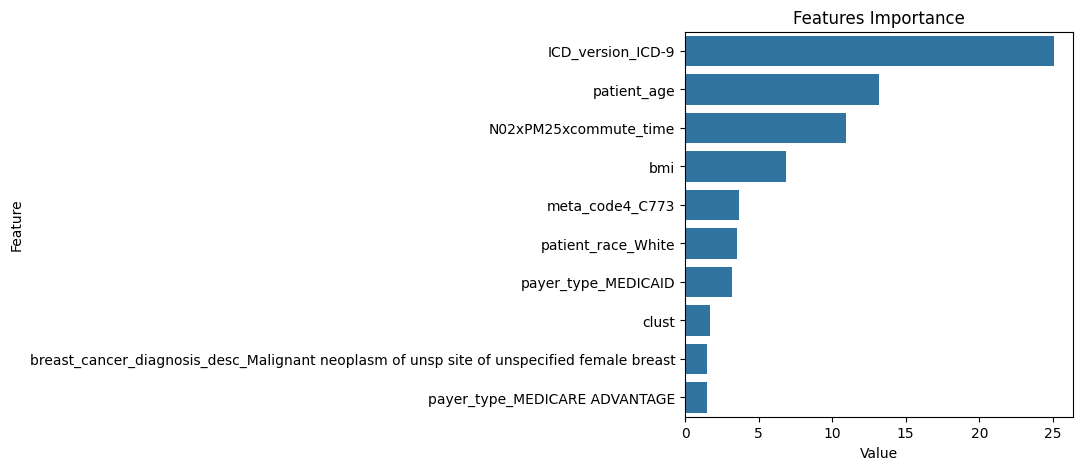

In [ ]:
# feature importance

feature_imp = pd.DataFrame(sorted(zip(modela.feature_importances_,cols)), columns = ['Value', 'Feature'])
feature_imp = feature_imp.sort_values("Value", ascending = False)
feature_imp = feature_imp.head(10)
feature_imp["Feature"] = feature_imp["Feature"]
plt.figure(figsize = (5, 5))
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
plt.title('Features Importance')
plt.tight_layout()
plt.savefig('cb_importances.png')
plt.show()

# Submission

In [ ]:
# blend predictions from all folds
final_predictions = predictions_from_folds.groupby("patient_id").mean().reset_index()
final_predictions[target] = final_predictions["pred"].values
final_predictions[ss.columns].to_csv("final_predictions.csv", index = None)

In [ ]:
from google.colab import files
files.download("final_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>